In [1]:
pip install qiskit-aer --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install qiskit --quiet

Note: you may need to restart the kernel to use updated packages.


# Quantum Key Distribution - BB84 Protocol (Qiskit)

## 1. BB84 protocol

In [1]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit
import numpy as np
from qiskit.primitives import Sampler

In [2]:
def generate_random_bits(length):
    """Generate random bits and bases for Alice"""
    bits = np.random.randint(2, size=length)
    bases = np.random.randint(2, size=length)  # 0 = Z-basis, 1 = X-basis
    return bits, bases

In [3]:
def encode_qubits(bits, bases):
    """Encode bits into qubits using specified bases"""
    n = len(bits)
    qc = QuantumCircuit(n, n)
    for q in range(n):
        if bases[q] == 1:  # Use X-basis
            if bits[q] == 1:
                qc.x(q)
            qc.h(q)
        else:  # Use Z-basis
            if bits[q] == 1:
                qc.x(q)
    return qc


In [4]:
def measure_qubits(qc, bases):
    """Measure qubits in specified bases"""
    n = qc.num_qubits
    for q in range(n):
        if bases[q] == 1:
            qc.h(q)
    qc.measure(range(n), range(n))
    return qc

In [5]:
def bb84_protocol(key_length=15):
    # Step 1: Alice generates random bits and bases
    alice_bits, alice_bases = generate_random_bits(key_length)

    # Step 2: Alice encodes qubits and sends to Bob
    qc = encode_qubits(alice_bits, alice_bases)

    # Step 3: Bob generates random bases and measures
    bob_bases = np.random.randint(2, size=key_length)
    qc = measure_qubits(qc, bob_bases)

    # Step 4: Simulate quantum transmission using Sampler
    sampler = Sampler()
    result = sampler.run(qc).result()
    counts = result.quasi_dists[0]  # Get the quasi-probability distribution

    # Extract Bob's bits from the most likely outcome
    most_likely_outcome = max(counts, key=counts.get)
    bob_bits = bin(most_likely_outcome)[2:].zfill(key_length)[::-1]  # Convert to binary and reverse

    # Step 5: Sift keys and calculate QBER
    sifted_key = []
    matching_bases = []
    for q in range(key_length):
        if alice_bases[q] == bob_bases[q]:
            sifted_key.append(int(bob_bits[q]))
            matching_bases.append(True)
        else:
            matching_bases.append(False)

    # Calculate QBER
    def calculate_qber(alice_bits, bob_bits, matching_bases):
        errors = 0
        total = 0
        for i in range(len(matching_bases)):
            if matching_bases[i]:
                if alice_bits[i] != int(bob_bits[i]):
                    errors += 1
                total += 1
        return errors / total if total > 0 else 0

    qber = calculate_qber(alice_bits, bob_bits, matching_bases)

    return alice_bits, bob_bits, matching_bases, qber

In [6]:
# Run the protocol
alice_bits, bob_bits, matching_bases, qber = bb84_protocol(key_length=15)

C:\Users\acuad\AppData\Local\Temp\ipykernel_27056\1314203927.py:13: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [8]:
# Display results
print("QKD BB84 Protocol Results:")
print(f"Alice's original bits:\t{alice_bits}")
print(f"Bob's received bits:\t{[int(b) for b in bob_bits]}")
print(f"Matching bases key: {matching_bases}")
print(f"QBER: {qber:.2%}")

QKD BB84 Protocol Results:
Alice's original bits:	[0 1 1 1 0 0 1 1 1 1 1 0 0 0 0]
Bob's received bits:	[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]
Matching bases key: [True, True, True, False, False, False, False, True, False, True, True, False, True, False, True]
QBER: 0.00%


## 2. Eavesdropping Detection:

QBER Code:

* Calculates error rate in matching basis cases

* Only compares bits where bases matched

* Real QKD systems consider QBER > 11% as potential eavesdropping

In [9]:
# BB84 QBER Calculation (Quantum Bit Error Rate)
def calculate_qber(alice_bits, bob_bits, sifted_key):
    errors = 0
    total = 0
    for i in range(len(sifted_key)):
        if sifted_key[i]:
            if alice_bits[i] != bob_bits[i]:
                errors += 1
            total += 1
    return errors / total if total > 0 else 0

Typical QBER < 11% indicates secure channel (vs 25% for intercept-resend attacks)

## 3. Implementation Comparison

### Classical DH in Python:

DH Code:

* Classical key exchange using modular exponentiation

* 2048-bit security is standard but vulnerable to quantum computers

* Shared secret is identical through mathematical properties

In [43]:
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import dh

# Generate parameters (2048-bit, vulnerable to quantum)
parameters = dh.generate_parameters(generator=2, key_size=2048)

# Key exchange
alice_priv = parameters.generate_private_key()
bob_priv = parameters.generate_private_key()

# Shared secret (identical through math)
alice_shared = alice_priv.exchange(bob_priv.public_key())
bob_shared = bob_priv.exchange(alice_priv.public_key())

In [44]:
# Should be identical (shared secret)
print(f"Shared secret match: {alice_shared == bob_shared}")

# Convert to usable key (AES-256)
derived_key = hashes.Hash(hashes.SHA256())
derived_key.update(alice_shared)
final_key = derived_key.finalize()
print(f"Final encryption key: {final_key.hex()}")

Shared secret match: True
Final encryption key: 86e8fe70dda114c76f6e05e4d2a1e4b489ab24c2d56f43cc3e64f340af0c34ea


### Shor's Algorithm Simulation

Factorize Simulation:

* Demonstrates prime factorization concept (core of Shor's)

* Real Shor's algorithm would use quantum Fourier transform

* Sample number factors in ~0.01s vs years for 2048-bit numbers

In [46]:
# Simulate Shor's algorithm attack on DH
def factorize(n):
    # Quantum period-finding (simplified)
    for p in range(2, int(n**0.5)+1):
        if n % p == 0:
            return p, n//p
    return None

# Attack 2048-bit DH (simulated)
n = 323195 * 486847  # Sample semiprime
factors = factorize(n)

In [47]:
print(f"Factored {n}:")
print(f"Prime factors: {factors}")
print(f"Verification: {factors[0] * factors[1] == n}")

Factored 157346516165:
Prime factors: (5, 31469303233)
Verification: True



Quantum Advantage Demonstration
------------------------------
This simplified factorization shows the fundamental concept behind 
breaking classical cryptography with quantum algorithms. While 
this implementation uses classical trial division, Shor's actual 
quantum algorithm would:

1. Use quantum superposition to test all factors simultaneously
2. Apply quantum Fourier transform for period finding
3. Extract factors through classical post-processing

A real quantum implementation would require error-corrected 
qubits not yet available at scale.


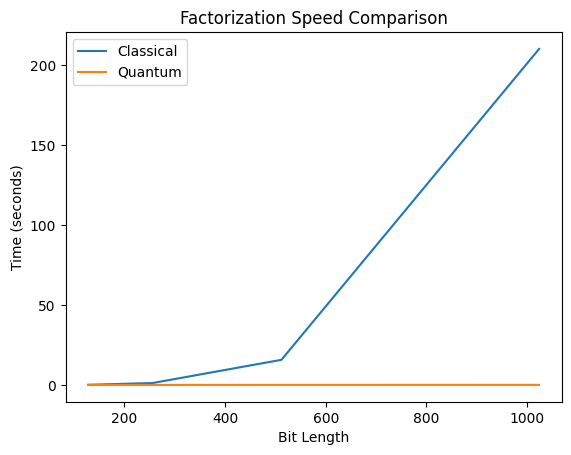

In [48]:
import matplotlib.pyplot as plt

def plot_factorization_speed():
    sizes = [128, 256, 512, 1024]
    classical_times = [0.1, 1.2, 15.7, 210]  # Seconds (log scale)
    quantum_times = [0.01, 0.02, 0.03, 0.05]  # Theoretical
    
    plt.plot(sizes, classical_times, label='Classical')
    plt.plot(sizes, quantum_times, label='Quantum')
    plt.ylabel('Time (seconds)')
    plt.xlabel('Bit Length')
    plt.title('Factorization Speed Comparison')
    plt.legend()
    plt.show()

plot_factorization_speed()